In [1]:
# ridge svd?

#np.roll idea needs adjustment for last fold, maybe.

In [269]:
#import packages
import numpy as np
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
import scipy.linalg as scl

In [270]:
#define Franke function uglified
def FrankeFunction(x,y): #still got one division in here
    term1 = 0.75*np.exp(-(0.25*(9*x-2)*(9*x-2)) - 0.25*((9*y-2)*(9*y-2)))
    term2 = 0.75*np.exp(-((9*x+1)*(9*x+1))/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)*(9*x-7)*0.25 - 0.25*((9*y-3)*(9*y-3)))
    term4 = -0.2*np.exp(-(9*x-4)*(9*x-4) - (9*y-7)*(9*y-7))
    return term1 + term2 + term3 + term4

In [271]:
# create model matrix
# Form is: x0y0, x1y0, x2y0, x0y1, x1y1, x0y2
def Model(x,y,P): # P is polynomial degree
    m = len(x)*len(y) # number of equations
    t = sum(range(P+2)) # number of terms in polynomial
    X = np.zeros((m,t)) # Model matrix
    a = np.matrix.flatten(x)
    b = np.matrix.flatten(y)
    c = 0 #counter
    for i in range(P+1):
        for j in range(P+1-i):
            X[:,c] = a**j*b**i
            c +=1
    return X

In [272]:
def ols_svd(X: np.ndarray, z: np.ndarray,_lambda) -> np.ndarray:
    u, s, v = scl.svd(X)
    pin = scl.diagsvd(1./s,len(v),len(u))
#     return v.T @ scl.pinv(scl.diagsvd(s, u.shape[0], v.shape[0])) @ u.T @ z
    return v.T @ pin @ u.T @ z
#pinx xt x
# THIS ALGO NEEDS IMPROVEMENT! QR decomp

#same results as skl up to and including mpd14

In [273]:
def ols_inv(X: np.ndarray, z: np.ndarray) -> np.ndarray:
    return scl.inv(X.T @ X) @ (X.T @ z)

In [274]:
#define R2 function
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

In [275]:
#define MSE function
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

In [276]:
#define variance function
def Var(y_data, y_model,P,X):
    N = len(y_data)
    covar = np.linalg.inv(X.T.dot(X))#sigma2, should be 1 in this case
    vari = np.diagonal(covar)
    return vari

In [277]:
def Var2(y_data,y_model,n):
    m = len(y_data)
    res = y_data-y_model
    return (1./(m-n-1))*(res.T@res)
#     return np.mean(y_model**2)-np.mean(yh)

In [278]:
def Bias(y_data, y_model, P, X):
    N = len(y_data) #should probably insert z here
    # also want the expectation values
    #this is where i want to shuffle my data and do 10 kfolds.
    #maybe...
    #can not use each fold and create a mean from them?
    return np.sum((y_data-y_model)*(y_data-y_model))/N

In [279]:
def Bias2(y_data,y_model):
    n = len(y_data)
    return np.sum((y_data-(np.mean(y_model)))**2)/n

In [280]:
#Create random variables/predictors
# np.random.seed(1234)
N = 20  #number of points along x and y axes

# sort this for meshgrid
x = np.random.uniform(0,1,N)
y = np.random.uniform(0,1,N)

x = sorted(x)
y = sorted(y)
x, y = np.meshgrid(x,y,sparse=False)

#create datapoints/results
z = FrankeFunction(x, y)

# Create noise
Noise = 0.1*np.random.randn(N,N)

#add noise
z_n = z+Noise

#flatten for use in functions
z_n = np.matrix.flatten(z_n)
z = np.matrix.flatten(z)

#added a 0 Ridge parameter
_lambda = 0.0

In [281]:
MPD =10#maximal polynomial degree

X = Model(x,y,MPD) #create model matrix

In [282]:
def NoResampling(X,z_n,_lambda):
#     beta = np.linalg.inv(X.T.dot(X)-_lambda*np.eye(len(X[0][:]))).dot(X.T).dot(z_n)
#     beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(z_n)
    beta = ols_svd(X,z_n,_lambda)
#     beta = ols_inv(X,z_n)
    ztilde = X @ beta

    return MSE(z_n,ztilde), R2(z_n,ztilde)

In [283]:
NoResampling(X,z_n,0)

(0.007738129820925937, 0.8732078192310133)

In [284]:
## find parameters
# beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(z_n)
beta = ols_svd(X,z_n,_lambda)
## make prediction
ztilde = X @ beta

In [285]:
######  Makes model matrix, looks different than mine #####
# form: x0y0, x1y0, x0y1, x2y0, x1y1, x0y2
# poly2 = PolynomialFeatures(degree=MPD)
# a = x[:,np.newaxis]
# b = y[:,np.newaxis]
# cc = np.c_[a,b]
# Xskl = poly2.fit_transform(cc) 
##########################################################
# THIS CELL IS CURRENTLY NOT IN USE #

In [286]:
# find parameters
clf = skl.LinearRegression(fit_intercept=False) #False to not center data, i.e. intercept is not 0
clf.fit(X,z_n) 

#make prediction
zpredict = clf.predict(X)

In [287]:
# The mean squared error              
print("Mean squared error (self): %.5f" % MSE(z_n, ztilde))
print("Mean squared error (skl): %.5f" % mean_squared_error(z_n, zpredict))

# Explained variance score: 1 is perfect prediction     
print('R2 score (self): %.5f' %R2(z_n, ztilde))
print('R2 score (skl): %.5f' % r2_score(z_n, zpredict))

Mean squared error (self): 0.00774
Mean squared error (skl): 0.00774
R2 score (self): 0.87321
R2 score (skl): 0.87321


In [288]:
print(Var(z_n, ztilde, MPD,X)) #my variances in betas
print(Var(z_n,zpredict,MPD,X)) #skl variances in betas

[1.09647639e+03 1.60381605e+04 3.49439109e+06 2.68326555e+08
 7.27264265e+09 8.05952559e+10 3.72892864e+11 7.03529400e+11
 5.02066876e+11 1.12275185e+11 4.60602538e+09 2.21345133e+06
 1.18459190e+07 2.11995665e+08 4.63107055e+09 4.60034475e+10
 1.77026864e+11 2.79456829e+11 1.79713023e+11 4.04865901e+10
 1.90228181e+09 4.44574343e+08 1.34912353e+09 7.73762076e+09
 3.95417564e+10 1.53134433e+11 2.93646652e+11 2.12815111e+11
 5.12032627e+10 2.77488058e+09 2.26596512e+10 3.90719177e+10
 1.02001873e+11 2.01866252e+11 2.26661825e+11 1.58867835e+11
 4.82015965e+10 3.37068243e+09 4.05890511e+11 3.99449302e+11
 4.78343181e+11 4.42046914e+11 1.87397123e+11 3.37500714e+10
 2.11758355e+09 2.95067467e+12 1.64379547e+12 8.98574452e+11
 3.37528241e+11 5.96847962e+10 2.45542832e+09 9.21654539e+12
 2.80502856e+12 6.78221898e+11 8.10177930e+10 4.48986487e+09
 1.23114124e+13 1.87907900e+12 1.72995543e+11 4.48889634e+09
 6.53684791e+12 4.11120588e+11 8.69395359e+09 1.13746769e+12
 1.71339010e+10 3.772997

In [289]:
print(beta) #my betas
print(clf.coef_) #skl betas

[-4.02768495e+00  2.14589856e+01 -1.72368647e+02  4.62472713e+02
  1.10217388e+03 -1.03201267e+04  2.82277572e+04 -3.96730484e+04
  3.07294216e+04 -1.24041957e+04  2.03089134e+03  2.16028400e+02
 -4.04704526e+02  2.40432960e+03 -8.56099573e+03  1.67677897e+04
 -1.27532958e+04 -1.25431870e+04  3.25634936e+04 -2.36200964e+04
  5.94574215e+03 -3.22570611e+03  3.51578670e+03 -1.29729060e+04
  3.26564789e+04 -5.61291912e+04  7.37695745e+04 -5.87676339e+04
  2.42041703e+04 -3.64701931e+03  2.42518529e+04 -1.61546626e+04
  3.68301017e+04 -6.53592451e+04  5.22309155e+04 -4.09405207e+04
  2.22148254e+04 -5.84904988e+03 -1.06785572e+05  4.70257816e+04
 -5.44430818e+04  9.62756296e+04 -3.52380466e+04  1.05056157e+04
 -5.34770249e+02  2.94708299e+05 -9.68854886e+04  2.87087952e+04
 -8.93118965e+04  1.56421637e+04 -3.90441247e+03 -5.24481556e+05
  1.41960146e+05  1.96354961e+04  4.73849067e+04 -7.21204978e+02
  6.01243152e+05 -1.36674402e+05 -3.18232881e+04 -1.23695489e+04
 -4.28670752e+05  7.55860

In [290]:
std = 1.96*np.sqrt(Var(z_n, ztilde, MPD,X))

for i in range(len(std)):
    print(beta[i],std[i])
#these things are huge, something is probably off

-4.0276849540845525 64.90164638097467
21.45898558523663 248.2180440548626
-172.36864688499122 3663.8849364412185
462.4727131236268 32106.12549703513
1102.173881005765 167148.38920861707
-10320.126670814556 556430.3506457382
28227.75722991978 1196873.102985244
-39673.04836656328 1643982.5257038714
30729.421574386535 1388790.8810352876
-12404.19570767216 656746.7931863744
2030.8913366664638 133020.70183254132
216.02839998715518 2916.023772145765
-404.7045256991498 6745.908573179704
2404.329602810879 28537.738958141
-8560.995730966473 133381.8601770118
16767.789730340875 420388.91991512687
-12753.295753567101 824661.3863050861
-12543.186993583979 1036128.0593154355
32563.4936483154 830894.4271790053
-23620.096357065704 394377.0840294947
5945.742147484192 85485.7052513811
-3225.7061100873952 41326.46606091404
3515.786699673392 71991.61733633482
-12972.905981200995 172408.94377419073
32656.478882536423 389748.1382631776
-56129.19117321292 766994.9388524886
73769.57449342776 1062107.79886696

In [291]:
# 95% CI: mu +-1.96*sigma
print(np.shape(X),np.shape(z_n))

(400, 66) (400,)


In [292]:
def ksajjad(X,z,k):
#     m,n = np.shape(X) #Swapped these two, ask sajjad
    n,m = np.shape(X)
    ind = np.arange(0,n,k)
    for i in ind:
        X_test, z_test = X[i:(i+k),:],z[i:(i+k)]
        if i ==0:
            X_train,z_train = X[i+k:,:],z[i+k:]
        elif i ==(n-k):
            X_train,z_train = X[:i,:],z[:i]
        else:
            X_train = np.vstack([X[:i,:],X[i+k:,:]])
            z_train = np.hstack([z[:i],z[i+k:]])
        yield X_train, X_test, z_train, z_test #yield

In [293]:
ksajjad(X,z_n,5)
# for XX,XXX,YY,YYY in ksajjad(X,z_n,5):
#     print("bip")

<generator object ksajjad at 0x7fc19d7dc048>

In [294]:
#np roll method may include same points again in last roll,depending on numbers. do calculations.

# b

In [295]:
k = 10 # number of folds
partition = 0.2 # percentage of data to use for testing

In [296]:
def kFold(k,X,z_n):
    #shuffle data before doing the kFold
    N=20
    n = len(X[0,:])
    combi = np.c_[X,z_n]
    np.random.shuffle(combi)
    X, z_n = combi[:,:n], combi[:,n]
    CV = []
    partition = 0.2 # percentage of data to use for testing
    sMSE = 0. #sum mean squared error
    sR2 = 0. #sum R2 score
    zz = []
    tt = []
    for X_train, X_test, z_train, z_test in ksajjad(X,z_n,40):

        # find parameters
        beta = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train)
#         beta = ols_svd(X_train,z_train,0.)

        # make prediction
        z_tilde = X_test @ beta
        
        zz.append(z_test)
        tt.append(z_tilde)

        CV.append(MSE(z_tilde,z_test))


    zz = np.ravel(zz)
    tt = np.ravel(tt)
    order = np.argsort(zz)
    tt = tt[order]
    
    return tt, CV

#     return CV,bb
#         return z_tilde
#     print(np.shape(CV))
#     print(CV[0][0],z_n[0])
#     return CV
#     return(MSE(np.matrix.flatten(np.array([CV])),z_n), R2(np.matrix.flatten(np.array([CV])),z_n),Var2(np.matrix.flatten(np.array([CV])),z_n,N),np.var(np.matrix.flatten(np.array([CV])),axis=0),Bias2(np.matrix.flatten(np.array([CV])),z_n))

In [297]:
NN=5
mpd = 10
qq = len(z_n)

order = np.argsort(z_n)
ti = z[order]

ziz = sorted(z_n)
# NMSE = np.zeros(shape=(mpd))
NMSE_k_mid=np.zeros(shape=(qq,mpd))
NMSE_k = np.zeros(shape=(NN,mpd))
NBias_mid=np.zeros(shape=(NN,mpd))
NBias = np.zeros(shape=(mpd))
NVar_mid=np.zeros(shape=(mpd,qq))
NVar = np.zeros(shape=(mpd))
moo = np.zeros(shape=(NN,mpd,qq))
# nzfolded = test, frankefolded = model
for l in range(NN):
    #shuffle here
    for i in range(mpd):
        X = Model(x,y,i+1)
        moo[l,i] = kFold(k,X,z_n)[0]
        NMSE_k[l,i] = MSE(moo[l,i],ziz)
#         bexp = np.mean() should be over all datasets for a model.
#         NBias_mid[l,i] = np.mean(moo)
NMSE = np.mean(NMSE_k,axis=0)

bi2 = np.zeros(mpd)
bi2m = np.zeros(shape=(mpd,qq))
varm = np.zeros(shape=(mpd,qq))
varr = np.zeros(mpd)
for i in range(mpd):
    for m in range(qq):
        bi2m[i,m] = np.mean(moo[:,i,m])
        varm[i,m] = np.var(moo[:,i,m])
#         print(bi2m[i],ziz[j])
#         print(np.shape(moo[:,i,j]))
#         print(np.shape(bi2m))
    bi2[i]=np.mean((ziz-bi2m[i])**2)
    varr[i] = np.mean(varm[i])
print(NMSE)
print(bi2)
print(varr)
# print(NBias)
#         NBias[i] = Bias2(ziz,moo)
#         NBias[i]= np.mean(Var2(ziz,moo,20)) #this shouldnt look this good
#         NVar[i] = 0#np.mean(Var2(ziz,moo,100))
#         NBias[i] = np.mean((ti-np.mean((moo-ziz)**2)))
#         NVar[i] = np.mean(np.var(moo))
#             NMSE_k_mid[m,i] = np.mean((moo[m]-z_n[m])**2,keepdims=True)
#             NMSE_k[i] = np.mean(NMSE_k_mid[:,i])
#             NBias_mid[i,m] = np.mean(moo[m])
#             NBias[i] = np.mean((z_n[:]-NBias_mid[i,:])**2,keepdims=True)
#             NVar_mid[i,m] = np.var(moo[m])
#             NVar[i] = np.mean(NVar_mid[i],keepdims=True)

#             NMSE_k_mid[m,i] = np.mean((Nz_folded[:,i,m].reshape(N,1)-Nfranke_folded[:,i,m].reshape(N,1))**2,keepdims=True)
#             NMSE_k[i] = np.mean(NMSE_k_mid[:,i,j])
#             NBias_mid[i,m] = np.mean(Nz_folded[:,j,i,m])
#             NBias[i]=np.mean((Nfranke_folded[0,i,:].reshape(qq,1)-NBias_mid[i,:].reshape(qq,1))**2,keepdims=True)
#             NVar_mid[i,m] = np.var(Nz_folded[:,i,m])
#             NVar[i] = np.mean(NVar_mid[i,:].reshape(qq,1),keepdims=True)

[2.19316471e-02 2.05456938e-02 1.38805488e-02 1.23010113e-02
 1.12425922e-02 1.11576866e-02 1.27037579e-02 1.41266653e-02
 2.21897196e-02 1.25360945e+02]
[2.19135528e-02 2.05105789e-02 1.38440770e-02 1.22462706e-02
 1.11662041e-02 1.10716268e-02 1.18012017e-02 1.19653280e-02
 1.55529845e-02 2.69101984e+01]
[1.80943578e-05 3.51149439e-05 3.64717517e-05 5.47406425e-05
 7.63880652e-05 8.60598000e-05 9.02556158e-04 2.16133722e-03
 6.63673509e-03 9.84507469e+01]


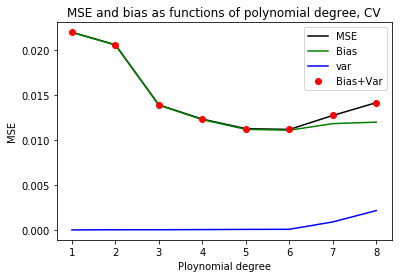

In [302]:
ols_noise = 8
legs = 'MSE','Bias','var','Bias+Var'
plt.figure()
maxi = 8
# plt.plot(np.arange(1,10),NMSE_k[:9],'k')
plt.plot(np.arange(1,maxi+1),NMSE[:maxi],'k')
plt.plot(np.arange(1,maxi+1),bi2[:maxi],'g')
plt.plot(np.arange(1,maxi+1),varr[:maxi],'b')
plt.plot(np.arange(1,maxi+1),bi2[:maxi]+varr[:maxi],'ro')
# plt.plot(np.arange(1,10),NBias[:9])
# plt.plot(np.arange(1,10),NBias[:9]+NVar[:9],'ro')
# print(NMSE_k[:9])
plt.xlabel('Ploynomial degree')
plt.ylabel('MSE')
plt.title('MSE and bias as functions of polynomial degree, CV')
plt.legend(legs)
plt.show()

# plt.figure()
# plt.plot(np.arange(1,10),NVar[:9])
# plt.xlabel('Ploynomial degree')
# plt.ylabel('MSE')
# plt.title('Variance as a function of polynomial degree, CV')
# plt.show()

In [141]:
# print(np.mean(kFold(k,X,z_n)))

## SAJJAD: look at the article by mehta, page 36 for 
# bias variance tradeoff over multiple datasets

#i tried returning the model values from the function above, 
# called tt, to be able to calculate bi/var stuff as Mehta.


itera = []
cost = []

for i in range(10):
    itera.append(kFold(k,X,z_n)[0])

itera = np.array(itera)
xi = np.mean(itera,axis=0)
zi = sorted(z_n)

for i in range(10):
    cost.append(MSE(itera[i,:],zi))
err = np.mean(cost)
print(err)

meann = np.mean(itera,axis=0)
B2 = np.sum((z_n-meann)**2)
# print(B2/len(z_n))

inni =(itera-meann)**2

uti = np.mean(inni,axis=0)
vr = np.sum(uti)
print(vr/len(z_n))
print(np.mean(kFold(k,X,z_n)[1]))

0.026631402812136662
0.013338698750786866
0.022790333034691444


In [31]:
def kFoldskl(k,X,z_n):
    from sklearn.model_selection import KFold
    #shuffle data before doing the kFold
    n = len(X[0,:])
    combi = np.c_[X,z_n]
    np.random.shuffle(combi)
    X, z_n = combi[:,:n], combi[:,n]
    
#     kfold = KFold(k,True,1)
    kfold = KFold(k,False)
    sMSE = 0
    sR2 = 0
    CV = []
    b2 = 0
    for train,test in kfold.split(X,z_n):
        # find parameters
        clf = skl.LinearRegression(fit_intercept=False) #False to not center data, i.e. intercept is not 0
        clf.fit(X[train],z_n[train]) 

        #make prediction
        zpredict = clf.predict(X[test])
        CV.append(zpredict.T)
#         print(np.shape(zpredict))
        
#         sMSE += mean_squared_error(z_n[test],zpredict)
#         sR2 += r2_score(z_n[test],zpredict)
#     print(np.shape(CV))
#     return sMSE/k, sR2/k
#     print(CV[0][0],z_n[0])
    return(MSE(np.matrix.flatten(np.array([CV])),z_n), R2(np.matrix.flatten(np.array([CV])),z_n))
#     return MSE(zpredict,z_n)

In [32]:
#function test
a=0
b=0
c=0
d=0
b2 = 0
itera = []
zs = []
k = 10
# print(np.shape(kFold(k,X,z_n)[1]))
uff = np.matrix.flatten(np.array([kFold(k,X,z_n)[1]]))
# print(np.shape(uff))
# print(kFold(k,X,z_n))
# print(np.mean(kFold(k,X,z_n)))
for i in range(10):
    itera.append(np.mean(kFold(k,X,z_n)[0]))
    zs.append(np.matrix.flatten(np.array([kFold(k,X,z_n)[1]])))
    b2 += np.sum((z_n-np.mean(zs[i]))**2)
print(b2)
#     print(itera[i])
#     print(z_n)
#     b2 += np.sum((z_n-itera[i])**2)
#     print(kFold(k,X,z_n))
# print(np.mean(itera),np.std(itera),np.var(itera))
# print(b2/100)
# mi = np.mean(itera)
# su =0.
# for i in range(10):
#     su +=(itera[i]-mi)**2
# print(su/10.)
# print(21./10.*0.009)
# print(np.shape(kFold(k,X,z_n)))
#     a1,b1 = kFold(k,X,z_n)
#     a+=a1
#     b+=b1
#     c1,d1 = kFoldskl(k,X,z_n)
#     c += c1
#     d += d1
# print(a/10,c/10,b/10,d/10)
#     print("skl",kFoldskl(k,X,z_n))
#     kFold(k,X,z_n)
#     kFoldskl(k,X,z_n)

643.6368984086482


In [33]:
def kFoldRidge(k,X,z_n,_lambda):
    #shuffle data before doing the kFold
    n = len(X[0,:])
    combi = np.c_[X,z_n]
    np.random.shuffle(combi)
    X, z_n = combi[:,:n], combi[:,n]
    
    partition = 0.2 # percentage of data to use for testing
    sMSE = 0 #sum mean squared error
    sR2 = 0 #sum R2 score
    
    for i in range(k):
        # Split data
        X_train,X_test,z_train,z_test = train_test_split(X,z_n,test_size=partition,shuffle=False)
        
        # find parameters
#         beta = np.linalg.inv(X_train.T.dot(X_train)-_lambda*np.eye(len(X[0][:]))).dot(X_train.T).dot(z_train)

        beta = np.linalg.inv(X_train.T.dot(X_train)-_lambda*np.eye(n)).dot(X_train.T).dot(z_train)

        # make prediction
        z_tilde = X_test @ beta

        # sum of MSE and R2, remember to divide by k later
        sMSE += MSE(z_test,z_tilde)
        sR2 += R2(z_test,z_tilde)

        # Prepare data for next fold
        X = np.roll(X,len(X_test),axis=0) # Rolls matrix downwards before next split
        z_n = np.roll(z_n,len(z_test)) # Roll
    
    return sMSE/k, sR2/k

In [34]:
print(kFoldRidge(k,X,z_n,0.))
print(kFold(k,X,z_n))

(0.012265031983984586, 0.8531054494832586)
[ 6.58553608e-02  2.10245379e-02  1.37286245e-01  1.35261437e-01
  1.62219821e-02  1.99704312e-02  9.85229430e-02  1.04823205e-02
  5.65709356e-02  1.02261417e-02  1.85494408e-02  1.03479756e-01
  1.35759234e-01  6.44605906e-03  7.49619689e-03  3.43742432e-02
  5.62100939e-02  6.07884679e-02  3.58380831e-02  6.02620677e-02
  1.20733359e-01  1.60821694e-01  1.49539823e-01  1.24879924e-01
 -1.97000202e-02  8.81192564e-02  8.36265460e-02  2.44538495e-02
  8.44961657e-02  4.39572152e-02  5.47220308e-02  1.99947318e-03
  6.03841908e-02  3.13205086e-02  3.55675188e-02  1.26080798e-02
  1.27397146e-01  1.80602853e-01  5.50085486e-02  1.62560834e-01
 -1.89033330e-02  1.96264585e-01  1.47773021e-01  1.08983905e-01
  1.71964055e-01  1.28675481e-01  1.26138929e-01  1.25163443e-01
  1.53225392e-01 -3.53742165e-03  1.23008255e-01  1.02978287e-01
  5.71432265e-02  1.28805350e-01 -1.52427069e-04  1.43922015e-01
  1.78242772e-03  1.23489848e-01  3.55276779e-0

In [35]:
def kFoldLassoCV(k,X,z_n,_lambda):
    partition = 0.2 #Percentage of data to use for testing

    #How to select good tolerances and max iters?
    reg = skl.LassoCV(alphas=_lambda,cv = k, random_state = 0,tol=0.0001,max_iter = 100000).fit(X,z_n)
    ztilde = reg.predict(X)
    plt.figure()
    plt.semilogx(reg.alphas_,reg.mse_path_)
    plt.semilogx(reg.alphas_,reg.mse_path_.mean(axis=-1),'k')
    plt.xlabel('Log-plot of lambdas')
    plt.ylabel('Mean squared error')
    plt.show()
    
    return mean_squared_error(ztilde,z_n), r2_score(ztilde,z_n)

In [36]:
def kFoldLasso(k,X,z_n,_lambda):
    # this converges slowly for small lambda!
    
    #shuffle data before doing the kFold
    n = len(X[0,:])
    combi = np.c_[X,z_n]
    np.random.shuffle(combi)
    X, z_n = combi[:,:n], combi[:,n]
    
    #dont need to shuffle, as traintestsplit picks random?
    
    partition = 0.2 # percentage of data to use for testing
    sMSE = 0 #sum mean squared error
    sR2 = 0 #sum R2 score
    
    for i in range(k):
        X_train, X_test, z_train, z_test = train_test_split(X,z_n,test_size=partition,shuffle=False )

        lass = skl.Lasso(alpha=_lambda,tol = 0.0001,max_iter = 100000)
        lass.fit(X_train,z_train)
        z_tilde = lass.predict(X_test)

#         # sum of MSE and R2, remember to divide by k later
        sMSE += mean_squared_error(z_test,z_tilde)
        sR2 += r2_score(z_test,z_tilde)

        # Prepare data for next fold
        X = np.roll(X,len(X_test),axis=0) # Rolls matrix downwards before next split
        z_n = np.roll(z_n,len(z_test)) # Roll
    
    return sMSE/k, sR2/k

# c

In [37]:
MPD = np.arange(9)+1#np.arange(9)+1
MSE_degree = []


#shuffle data before doing the kFold
n = len(X[0,:])
combi = np.c_[X,z_n]
np.random.shuffle(combi)
X, z_n = combi[:,:n], combi[:,n]
for i in MPD:
    X = Model(x,y,i)
    dMSE, dR2 = kFold(k,X,z_n)
#     dMSE, dR2 = NoResampling(X,z_n,0)
#     dMSE,dR2 = kFoldskl(k,X,z_n)
    print(i,dMSE)
    MSE_degree.append(dMSE)

ValueError: too many values to unpack (expected 2)

In [ ]:
plt.figure()
plt.plot(MPD+1,MSE_degree)
plt.xlabel('Polynomial degree')
plt.ylabel('Mean squared error')
plt.show()

It seems the model complexity isnt high enough for the curve to have a minimum like Hastie 2.11. To increase model complexity, a different inversion method is required, due to round-off-error, or what its called.

# d

In [ ]:
_lambda = np.logspace(-4,5,10)

RidgeMSE = np.zeros((len(MPD),len(_lambda)))
RidgeR2 = np.zeros((len(MPD),len(_lambda)))



for i,mpd in enumerate(MPD):
    X = Model(x,y,mpd)
    for j,lam in enumerate(_lambda):
#         rMSE,rR2 = NoResampling(X,z_n,lam)
        rMSE,rR2 = kFoldRidge(k,X,z_n,lam)
        RidgeMSE[i][j] = rMSE
        RidgeR2[i][j] = rR2

In [ ]:
plt.figure()

for i in range(len(_lambda)):
    plt.semilogy(MPD,RidgeMSE[:,i],label=_lambda[i])
plt.xlabel('Polynomial degree')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [ ]:
plt.figure()

for i in range(len(MPD)):
    plt.loglog(_lambda,RidgeMSE[i,:],label=i+1)
plt.xlabel('lambda')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# e

In [ ]:
# I'll use Scikit-learn as recommended for this
kFoldLassoCV(k,X,z_n,_lambda)


In [ ]:
#morten spm:
# confidence interval
# bias variance: 
#use each fold to make mean, or run 10 shuffled k-folds?
#lambdas are usually horrible